In [1]:
#### import random

import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import matplotlib.ticker as tck
import matplotlib.ticker as ticker
import matplotlib.colors as colors

from scipy.linalg    import eig
from scipy.linalg    import eigh

from numpy.linalg import det
from numpy.linalg import inv

from scipy.special import iv
from scipy.special import jv
from scipy.special import kv
from scipy.special import gamma as gammaf
from scipy.special import factorial
from scipy.special import hyp2f1
from scipy.integrate import quad

from scipy.integrate import quad
from tqdm            import tqdm

from mpl_toolkits.axes_grid1 import make_axes_locatable

mpl.rcParams['figure.dpi'] = 100

In [2]:
def grid(rmin,rmax,nx,spacing):
    if spacing == "log":
        
        f   =  1/(nx-1)*np.log(rmax/rmin)
        d_r =  rmin/2*(1-1/np.exp(f))

        rc = (rmin    )*np.exp(f*(np.arange(nx  ))) #arange -> 0 to nx-1
        re = (rmin-d_r)*np.exp(f*(np.arange(nx+1))) #arange -> 0 to nx
        
    elif spacing == "lin":
        rc  = np.linspace(rmin,rmax,nx)
        dr  = rc[1]-rc[0]
        re  = np.linspace(rmin-dr/2,rmax+dr/2,nx+1)
    
    return np.asarray(re),np.asarray(rc)

In [3]:
nx         = 2000
Mdisk_perc = 0.4
m          = 2

rin        = 0.15
rD         = 1.0
spacing    = "lin"
re,r       = grid(rin,rD,nx,spacing)
G          = 1.0
K          = 0.25
M          = 0.6
gammap     = 2.0
Md         = (Mdisk_perc*M)/(1.0-Mdisk_perc)

f = np.copy(gammap)
b = 2

#profile = "bump"
profile = "power"

extention = profile+"_"+str(nx)+"_"+str(int(rin*100))+"_"+str(int(rD*100))+"_"+spacing+"_"+str(m)+"_"+str(int(Mdisk_perc*100))+"_"+str(int(gammap*10))+"_"+str(b)

print(extention)

power_2000_15_100_lin_2_40_20_2


In [4]:
if profile == "power":
    R0    = 1.0
    slope = 1.5

    def integral_disk_mass(r, R0, slope):
        return (r/R0)**(-slope) * r * 2*np.pi

    Id  = quad(integral_disk_mass, rin, rD, args=(R0,slope))

    print(Id)
    s0           = (Mdisk_perc*M)/(1.0-Mdisk_perc)/Id[0]
    sigma0       = s0*(r/R0)**(-slope) 

    def sigma0_f(ri): return s0*(ri/R0)**(-slope) 

    dsigma0_dr   = s0/(R0**(-slope))*(-slope)*r**(-slope-1)
    dsigma02_dr2 = s0/(R0**(-slope))*(-slope)*(-slope-1)*r**(-slope-2)
    dsigma03_dr3 = s0/(R0**(-slope))*(-slope)*(-slope-1)*(-slope-2)*r**(-slope-3)


    #print(simpson(sigma0*r*2*np.pi,r))
    print("Md:",Md)

elif profile == "bump":
    R0         = 0.45
    delta_w2   = 0.05

    def integral_disk_mass(r, R0, delta_w2):
        return np.exp(-(r-R0)**2/(delta_w2)) * r * 2*np.pi

    Id  = quad(integral_disk_mass, rin, rD, args=(R0,delta_w2))

    s0           = (Mdisk_perc*M)/(1.0-Mdisk_perc)/Id[0]
    sigma0       = s0*np.exp(-(r-R0)**2/(delta_w2))

    def sigma0_f(ri): return s0*np.exp(-(ri-R0)**2/(delta_w2))

    dsigma0_dr   = (-2*(r-R0)/delta_w2)*sigma0
    dsigma02_dr2 = 4*sigma0*(r-R0)**2/delta_w2**2 - 2*sigma0/delta_w2
    dsigma03_dr3 = -8*sigma0*(r-R0)**3/delta_w2**3+12*sigma0*(r-R0)/delta_w2**2

(7.699436203190904, 7.436560408352107e-08)
Md: 0.4


In [5]:
def K_ij_m_F(ri,rj,m):
    alpha = np.min([ri,rj])/np.max([ri,rj])
    b_12  = gammaf(0.5+m)/gammaf(0.5)/factorial(m)*np.abs(alpha**(m))*hyp2f1(0.5,0.5+m,m+1,alpha**2)
    return alpha**(1/2)/np.sqrt(ri*rj)*b_12

def P_f_NC_F(nx,n,ns):
        
    phi0_l = []
    
    for i in tqdm(range(0,nx),desc=""):

        phi0_i = 0
        for j in range(0,nx):

            if i == j:
                r_a = re[i]
                r_b = r[i]
                r_c = re[i+1]
            
                
                #Sub division of ns close NC intervals
                h_ns_1  = (r_b-r_a)/(ns+1)
                h_ns_2  = (r_c-r_b)/(ns+1)

                r_ns_1 = []
                r_ns_2 = []

                for ns_i in range(0,ns+2):
                    r_ns_1.append(r_a + ns_i*h_ns_1)
                    r_ns_2.append(r_b + ns_i*h_ns_2)
                
                Kii = 0
                if ns > 0:
                    for ns_i in range(0,ns):
                        Kii += (np.sqrt(r[i]*r_ns_1[ns_i])  *K_ij_m_F(r[i],r_ns_1[ns_i]  ,0)+np.sqrt(r[i]*r_ns_1[ns_i+1])*K_ij_m_F(r[i],r_ns_1[ns_i+1],0))*(r_ns_1[ns_i+1]-r_ns_1[ns_i])/2
                        Kii += (np.sqrt(r[i]*r_ns_2[ns_i+1])*K_ij_m_F(r[i],r_ns_2[ns_i+1],0)+np.sqrt(r[i]*r_ns_2[ns_i+2])*K_ij_m_F(r[i],r_ns_2[ns_i+2],0))*(r_ns_2[ns_i+2]-r_ns_2[ns_i+1])/2
     
                #limits for open NC
                r_a_s = r_ns_1[ns]
                r_b_s = r_ns_1[-1] # or r_ns_2[0]
                r_c_s = r_ns_2[1]

                h_1 = (r_b_s-r_a_s)/(n+2)
                h_2 = (r_c_s-r_b_s)/(n+2)       

                r_1_l = []
                r_2_l = []

                for ii in range(0,n+1):
                    r_1_l.append(r_a_s + (ii + 1) * h_1)
                    r_2_l.append(r_b_s + (ii + 1) * h_2)

                n_coeff = [np.array([1])*2, #n=1 (mid-point)
                           np.array([1,1])*3/2, #n=2
                           np.array([2,-1,2])*4/3, #n=3
                           np.array([11,1,1,11])*5/24, #n=4
                           np.array([11,-14 ,26,-14,11])*6/20, #n=5
                           np.array([611,-453,562,562,-453,611])*7/1440, #n=6
                           np.array([460,-954,2196,-2459,2196,-954,460])*8/954 #n=7
                          ] 

                for ni in range(0,n+1):
                    
                    Kii += n_coeff[n][ni]*np.sqrt(r[i]*r_1_l[ni])*K_ij_m_F(r[i],r_1_l[ni],0)*h_1
                    Kii += n_coeff[n][ni]*np.sqrt(r[i]*r_2_l[ni])*K_ij_m_F(r[i],r_2_l[ni],0)*h_2
                
                dr   = (r_c - r_a)
                Kii /= r[i]*dr
                
                phi0_i += -2*np.pi*G*Kii*r[j]*sigma0_f(r[j])*dr
  
            else:

                Kij = K_ij_m_F(r[i],r[j],0)
                r_a = re[j]
                r_c = re[j+1]
                
                phi0_i += -2*np.pi*G*Kij*r[j]*sigma0_f(r[j])*(r_c-r_a)     
        
        phi0_l.append(phi0_i)

    return phi0_l

In [6]:
phi0 = P_f_NC_F(nx,6,100)

100%|███████████████████████████████████████████████████████████| 2000/2000 [00:44<00:00, 44.74it/s]


In [7]:
dphi0_dr   = np.gradient(phi0,r,edge_order=2)
dphi02_dr2 = np.gradient(dphi0_dr  ,r,edge_order=2)
dphi03_dr3 = np.gradient(dphi02_dr2,r,edge_order=2)

In [8]:
omegaK = np.sqrt(G*M/r**3)

omega  = np.sqrt(omegaK**2 +
                 K*gammap*sigma0**(gammap-2)/r*dsigma0_dr + 
                 dphi0_dr/r)

domega_dr  = K*r**3*(-2+gammap)*gammap*sigma0**gammap*dsigma0_dr**2
domega_dr += K*r**2*gammap*sigma0**(1+gammap)*(-dsigma0_dr+r*dsigma02_dr2)
domega_dr += sigma0**3*(-3*G*M-r**2*dphi0_dr+r**3*dphi02_dr2)
domega_dr /= 2*r**4*sigma0**3*np.sqrt((G*M+K*r**2*gammap*sigma0**(-2+gammap)*dsigma0_dr+r**2*dphi0_dr)/r**3)

domega2_dr2  = -(K*r**3*(-2+gammap)*gammap*sigma0**gammap*dsigma0_dr**2+K*r**2*gammap*sigma0**(1+gammap)*(-dsigma0_dr+r*dsigma02_dr2)+sigma0**3*(-3*G*M-r**2*dphi0_dr+r**3*dphi02_dr2))**2
domega2_dr2 += 2*(K*r**2*gammap*sigma0**gammap*dsigma0_dr+sigma0**2*(G*M+r**2*dphi0_dr)) * (K*r**4*gammap*(6-5*gammap+gammap**2)*sigma0**gammap*dsigma0_dr**3+K*r**3*(-2+gammap)*gammap*sigma0**(1+gammap)*dsigma0_dr*(-2*dsigma0_dr+3*r*dsigma02_dr2)+K*r**2*gammap*sigma0**(2+gammap)*(2*dsigma0_dr+r*(-2*dsigma02_dr2+r*dsigma03_dr3))+sigma0**4*(12*G*M+2*r**2*dphi0_dr-2*r**3*dphi02_dr2+r**4*dphi03_dr3))
domega2_dr2 /= 4*r**8*sigma0**6*((G*M+K*r**2*gammap*sigma0**(-2+gammap)*dsigma0_dr+r**2*dphi0_dr)/r**3)**(3/2)


kappa      = np.sqrt(2*omega*(2*omega+r*domega_dr))
dkappa_dr  = (r*domega_dr**2+omega*(5*domega_dr+r*domega2_dr2))/(np.sqrt(2*(omega*(2*omega+r*domega_dr))))

cs2        = K*gammap*sigma0**(gammap-1.0)
cs         = np.sqrt(cs2)

dcs_dr   = (-1+gammap)*np.sqrt(K*gammap*sigma0**(-1+gammap))*dsigma0_dr/(2*sigma0)
dcs2_dr2 = (-1+gammap)*np.sqrt(K*gammap*sigma0**(-1+gammap))*((-3+gammap)*dsigma0_dr**2+2*sigma0*dsigma02_dr2)/(4*sigma0**2)

dcs2_dr    = K*gammap*(gammap-1.0)*sigma0**(gammap-2.0)*dsigma0_dr
dcs22_dr2  = K*gammap*(gammap-1.0)*((gammap-2.0)*sigma0**(gammap-3.0)*dsigma0_dr**2 + sigma0**(gammap-2)*dsigma02_dr2)

In [9]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [10]:
r_idx_1 = find_nearest(omega , np.max(omega-kappa/m))
r_idx_2 = find_nearest(omega , np.min(omega+kappa/m))

omega_root_min = np.min([omega[r_idx_1],omega[r_idx_2]])
omega_root_max = np.max([omega[r_idx_1],omega[r_idx_2]])

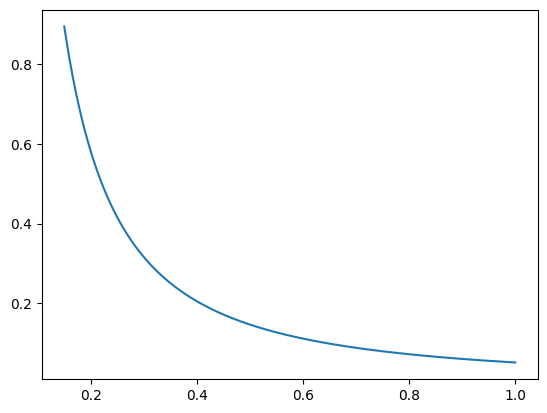

In [11]:
plt.plot(r,sigma0)

2.1004068181319826
3.2207784536872723


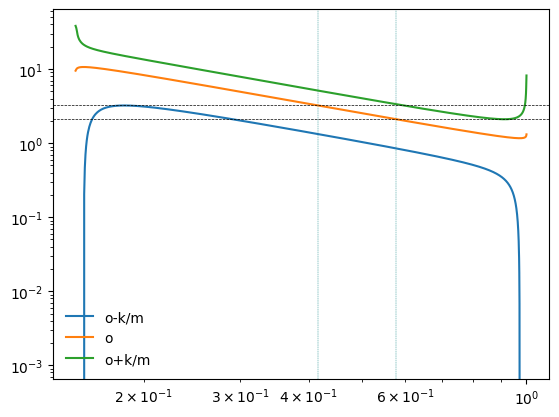

In [12]:
plt.figure(figsize=(6.4, 4.8))

plt.axvline(r[r_idx_1],lw=0.3,ls="dashed",color="teal")#,label=r"min($\Omega$)")
plt.axvline(r[r_idx_2],lw=0.3,ls="dashed",color="teal")#,label=r"max($\Omega$)")

plt.plot(r,omega-kappa/m,label="o-k/m")
plt.plot(r,omega,label="o")
#plt.plot(r,kappa,label="k")
plt.plot(r,omega+kappa/m,label="o+k/m")
plt.legend(frameon=False)

plt.axhline(np.min(omega+kappa/m),color="black",lw=0.5,ls="--")
plt.axhline(np.max(omega-kappa/m),color="black",lw=0.5,ls="--")

print(omega_root_min)
print(omega_root_max)
plt.xscale("log")
plt.yscale("log")

In [13]:
def P1_f_NC_F(nx,n,ns,m):
        
    phi1_M = np.zeros((nx,nx),dtype=complex)
    
    for i in tqdm(range(0,nx),desc=""):
        for j in range(0,nx):

            if i == j:
                r_a = re[i]
                r_b = r[i]
                r_c = re[i+1]
            
                
                #Sub division of ns close NC intervals
                h_ns_1  = (r_b-r_a)/(ns+1)
                h_ns_2  = (r_c-r_b)/(ns+1)

                r_ns_1 = []
                r_ns_2 = []

                for ns_i in range(0,ns+2):
                    r_ns_1.append(r_a + ns_i*h_ns_1)
                    r_ns_2.append(r_b + ns_i*h_ns_2)
                
                Kii = 0
                if ns > 0:
                    for ns_i in range(0,ns):
                        Kii += (np.sqrt(r[i]*r_ns_1[ns_i])  *K_ij_m_F(r[i],r_ns_1[ns_i]  ,m)+np.sqrt(r[i]*r_ns_1[ns_i+1])*K_ij_m_F(r[i],r_ns_1[ns_i+1],m))*(r_ns_1[ns_i+1]-r_ns_1[ns_i])/2
                        Kii += (np.sqrt(r[i]*r_ns_2[ns_i+1])*K_ij_m_F(r[i],r_ns_2[ns_i+1],m)+np.sqrt(r[i]*r_ns_2[ns_i+2])*K_ij_m_F(r[i],r_ns_2[ns_i+2],m))*(r_ns_2[ns_i+2]-r_ns_2[ns_i+1])/2
     
                #limits for open NC
                r_a_s = r_ns_1[ns]
                r_b_s = r_ns_1[-1] # or r_ns_2[0]
                r_c_s = r_ns_2[1]

                h_1 = (r_b_s-r_a_s)/(n+2)
                h_2 = (r_c_s-r_b_s)/(n+2)       

                r_1_l = []
                r_2_l = []

                for ii in range(0,n+1):
                    r_1_l.append(r_a_s + (ii + 1) * h_1)
                    r_2_l.append(r_b_s + (ii + 1) * h_2)

                n_coeff = [np.array([1])*2, #n=1 (mid-point)
                           np.array([1,1])*3/2, #n=2
                           np.array([2,-1,2])*4/3, #n=3
                           np.array([11,1,1,11])*5/24, #n=4
                           np.array([11,-14 ,26,-14,11])*6/20, #n=5
                           np.array([611,-453,562,562,-453,611])*7/1440, #n=6
                           np.array([460,-954,2196,-2459,2196,-954,460])*8/954 #n=7
                          ] 

                for ni in range(0,n+1):
                    
                    Kii += n_coeff[n][ni]*np.sqrt(r[i]*r_1_l[ni])*K_ij_m_F(r[i],r_1_l[ni],m)*h_1
                    Kii += n_coeff[n][ni]*np.sqrt(r[i]*r_2_l[ni])*K_ij_m_F(r[i],r_2_l[ni],m)*h_2
                
                dr   = (r_c - r_a)
                Kii /= r[i]*dr
                
                phi1_M[i,j] = -2*np.pi*G*Kii*r[j]*dr
  
            else:

                Kij = K_ij_m_F(r[i],r[j],m)
                r_a = re[j]
                r_c = re[j+1]
                
                phi1_M[i,j] = -2*np.pi*G*Kij*r[j]*(r_c-r_a)     

    return phi1_M

In [14]:
I  = np.identity(nx,dtype=complex)
D1 = np.zeros((nx,nx),dtype=complex)
D2 = np.zeros((nx,nx),dtype=complex)

for i in range(0,nx): 
    for k in range(0,nx):
        
        if i == 0:
            pass
            D1[i,0:3] = [-3, 4,-1]
            D2[i,0:4] = [2 ,-5, 4,-1]
            
        elif i == nx-1:
            pass
            D1[i,-3:] = [   1,-4,3]
            D2[i,-4:] = [-1,4,-5,2]
            
        else:
            if i==k:
                D1[i,k-1:k+1+1] = [-1,0 ,1]
                D2[i,k-1:k+1+1] = [1 ,-2,1]

if spacing == "lin":
    dr = r[1]-r[0]
    D1 /= 2*dr
    D2 /= dr**2

elif spacing == "log":
    log_f =  1/(nx-1)*np.log(rD/rin)
    D1 /= 2*log_f
    D2 /= log_f**2

In [15]:
phi1 = P1_f_NC_F(nx,6,100,m)

100%|███████████████████████████████████████████████████████████| 2000/2000 [00:45<00:00, 44.35it/s]


In [16]:
def P1_f_S(nx):
    phi1_M = np.zeros((nx,nx),dtype=complex)

    for i in tqdm(range(0,nx),desc=""):
    
        for j in range(0,nx):
            
            r_a    = re[j]
            r_c    = re[j+1]

            phi1_M[i,j] = r[i]*np.pi/(M+Md)*r[j]**2*(r_c-r_a)
            
    return phi1_M

In [17]:
if m == 1:
    phi1s = P1_f_S(nx)
else: 
    phi1s = np.zeros((nx,nx),dtype=complex)

In [18]:
h1 = cs2/sigma0*I

In [19]:
s       = np.copy(sigma0)
ds_dr   = np.copy(dsigma0_dr)
ds2_dr2 = np.copy(dsigma02_dr2)

o       = np.copy(omega)
do_dr   = np.copy(domega_dr)
do2_dr2 = np.copy(domega2_dr2)

k     = np.copy(kappa)
dk_dr = np.copy(dkappa_dr)

def order5(Ylist,w,factor):
    return w**0*Ylist[0]*factor + w**1*Ylist[1]*factor + w**2*Ylist[2]*factor + w**3*Ylist[3]*factor + w**4*Ylist[4]*factor + w**5*Ylist[5]*factor

## Second-Order Terms

In [20]:
Y1 = [(f**3*((1j*b**3*m**6*o**6)/(k**2)-(3*b**2*m**5*o**6)/(k**2)-1j*b**3*m**4*o**4-(3*1j*b*m**4*o**6)/(k**2)+3*b**2*m**3*o**4+(m**3*o**6)/(k**2)+3*1j*b*m**2*o**4-m*o**4))/(k),
(f**3*(-(6*1j*b**3*m**5*o**5)/(k**2)+(15*b**2*m**4*o**5)/(k**2)+4*1j*b**3*m**3*o**3+(12*1j*b*m**3*o**5)/(k**2)-9*b**2*m**2*o**3-(3*m**2*o**5)/(k**2)-6*1j*b*m*o**3+o**3))/(k),
(f**3*((15*1j*b**3*m**4*o**4)/(k**2)-(30*b**2*m**3*o**4)/(k**2)-6*1j*b**3*m**2*o**2-(18*1j*b*m**2*o**4)/(k**2)+9*b**2*m*o**2+(3*m*o**4)/(k**2)+3*1j*b*o**2))/(k),
(f**3*(-(20*1j*b**3*m**3*o**3)/(k**2)+(30*b**2*m**2*o**3)/(k**2)+4*1j*b**3*m*o+(12*1j*b*m*o**3)/(k**2)-3*b**2*o-(o**3)/(k**2)))/(k),
(f**3*(-1j*b**3+(15*1j*b**3*m**2*o**2)/(k**2)-(15*b**2*m*o**2)/(k**2)-(3*1j*b*o**2)/(k**2)))/(k),
(f**3*((3*b**2*o)/(k**2)-(6*1j*b**3*m*o)/(k**2)))/(k),
(1j*b**3*f**3)/(k**3),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex)]

In [21]:
YA = [-(1j*f**3*(-b**3*m**6*r*o**6*ds_dr+2*b**3*m**6*r*s*o**5*do_dr-b**3*m**6*s*o**6-3*1j*b**2*m**5*r*o**6*ds_dr+6*1j*b**2*m**5*r*s*o**5*do_dr-3*1j*b**2*m**5*s*o**6-2*b**3*m**4*r*k*s*o**4*dk_dr+b**3*m**4*r*k**2*o**4*ds_dr+b**3*m**4*k**2*s*o**4+3*b*m**4*r*o**6*ds_dr-6*b*m**4*r*s*o**5*do_dr+3*b*m**4*s*o**6-6*1j*b**2*m**3*r*k*s*o**4*dk_dr+3*1j*b**2*m**3*r*k**2*o**4*ds_dr+3*1j*b**2*m**3*k**2*s*o**4+1j*m**3*r*o**6*ds_dr-2*1j*m**3*r*s*o**5*do_dr+1j*m**3*s*o**6+6*b*m**2*r*k*s*o**4*dk_dr-3*b*m**2*r*k**2*o**4*ds_dr-3*b*m**2*k**2*s*o**4+2*1j*m*r*k*s*o**4*dk_dr-1j*m*r*k**2*o**4*ds_dr-1j*m*k**2*s*o**4))/(r*k**3*s),
-(1j*f**3*(6*b**3*m**5*r*o**5*ds_dr-10*b**3*m**5*r*s*o**4*do_dr+6*b**3*m**5*s*o**5+15*1j*b**2*m**4*r*o**5*ds_dr-24*1j*b**2*m**4*r*s*o**4*do_dr+15*1j*b**2*m**4*s*o**5+8*b**3*m**3*r*k*s*o**3*dk_dr-4*b**3*m**3*r*k**2*o**3*ds_dr-4*b**3*m**3*k**2*s*o**3-12*b*m**3*r*o**5*ds_dr+18*b*m**3*r*s*o**4*do_dr-12*b*m**3*s*o**5+18*1j*b**2*m**2*r*k*s*o**3*dk_dr-9*1j*b**2*m**2*r*k**2*o**3*ds_dr-9*1j*b**2*m**2*k**2*s*o**3-3*1j*m**2*r*o**5*ds_dr+4*1j*m**2*r*s*o**4*do_dr-3*1j*m**2*s*o**5-12*b*m*r*k*s*o**3*dk_dr+6*b*m*r*k**2*o**3*ds_dr+6*b*m*k**2*s*o**3-2*1j*r*k*s*o**3*dk_dr+1j*r*k**2*o**3*ds_dr+1j*k**2*s*o**3))/(r*k**3*s),
-(1j*f**3*(-15*b**3*m**4*r*o**4*ds_dr+20*b**3*m**4*r*s*o**3*do_dr-15*b**3*m**4*s*o**4-30*1j*b**2*m**3*r*o**4*ds_dr+36*1j*b**2*m**3*r*s*o**3*do_dr-30*1j*b**2*m**3*s*o**4-12*b**3*m**2*r*k*s*o**2*dk_dr+6*b**3*m**2*r*k**2*o**2*ds_dr+6*b**3*m**2*k**2*s*o**2+18*b*m**2*r*o**4*ds_dr-18*b*m**2*r*s*o**3*do_dr+18*b*m**2*s*o**4-18*1j*b**2*m*r*k*s*o**2*dk_dr+9*1j*b**2*m*r*k**2*o**2*ds_dr+9*1j*b**2*m*k**2*s*o**2+3*1j*m*r*o**4*ds_dr-2*1j*m*r*s*o**3*do_dr+3*1j*m*s*o**4+6*b*r*k*s*o**2*dk_dr-3*b*r*k**2*o**2*ds_dr-3*b*k**2*s*o**2))/(r*k**3*s),
-(1j*f**3*(20*b**3*m**3*r*o**3*ds_dr-20*b**3*m**3*r*s*o**2*do_dr+20*b**3*m**3*s*o**3+30*1j*b**2*m**2*r*o**3*ds_dr-24*1j*b**2*m**2*r*s*o**2*do_dr+30*1j*b**2*m**2*s*o**3+8*b**3*m*r*k*s*o*dk_dr-4*b**3*m*r*k**2*o*ds_dr-4*b**3*m*k**2*s*o-12*b*m*r*o**3*ds_dr+6*b*m*r*s*o**2*do_dr-12*b*m*s*o**3+6*1j*b**2*r*k*s*o*dk_dr-3*1j*b**2*r*k**2*o*ds_dr-3*1j*b**2*k**2*s*o-1j*r*o**3*ds_dr-1j*s*o**3))/(r*k**3*s),
-(1j*f**3*(-15*b**3*m**2*r*o**2*ds_dr+10*b**3*m**2*r*s*o*do_dr-15*b**3*m**2*s*o**2-15*1j*b**2*m*r*o**2*ds_dr+6*1j*b**2*m*r*s*o*do_dr-15*1j*b**2*m*s*o**2-2*b**3*r*k*s*dk_dr+b**3*r*k**2*ds_dr+b**3*k**2*s+3*b*r*o**2*ds_dr+3*b*s*o**2))/(r*k**3*s),
-(1j*f**3*(6*b**3*m*r*o*ds_dr-2*b**3*m*r*s*do_dr+6*b**3*m*s*o+3*1j*b**2*r*o*ds_dr+3*1j*b**2*s*o))/(r*k**3*s),
-(1j*f**3*(b**3*(-r)*ds_dr-b**3*s))/(r*k**3*s),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex)]

In [22]:
YB = [-(1j*f**3*m*(b**3*m**7*s*o**6+3*1j*b**2*m**6*s*o**6-b**3*m**5*k**2*s*o**4-2*b**3*m**5*r*o**6*ds_dr+2*b**3*m**5*r*s*o**5*do_dr-3*b*m**5*s*o**6-3*1j*b**2*m**4*k**2*s*o**4-6*1j*b**2*m**4*r*o**6*ds_dr+6*1j*b**2*m**4*r*s*o**5*do_dr-1j*m**4*s*o**6-4*b**3*m**3*r*k*s*o**4*dk_dr+2*b**3*m**3*r*k**2*o**4*ds_dr+2*b**3*m**3*r*k**2*s*o**3*do_dr+3*b*m**3*k**2*s*o**4+6*b*m**3*r*o**6*ds_dr-6*b*m**3*r*s*o**5*do_dr-12*1j*b**2*m**2*r*k*s*o**4*dk_dr+6*1j*b**2*m**2*r*k**2*o**4*ds_dr+6*1j*b**2*m**2*r*k**2*s*o**3*do_dr+1j*m**2*k**2*s*o**4+2*1j*m**2*r*o**6*ds_dr-2*1j*m**2*r*s*o**5*do_dr+12*b*m*r*k*s*o**4*dk_dr-6*b*m*r*k**2*o**4*ds_dr-6*b*m*r*k**2*s*o**3*do_dr+4*1j*r*k*s*o**4*dk_dr-2*1j*r*k**2*o**4*ds_dr-2*1j*r*k**2*s*o**3*do_dr))/(r**2*k**3*s),
-(1j*f**3*m*(-6*b**3*m**6*s*o**5-15*1j*b**2*m**5*s*o**5+4*b**3*m**4*k**2*s*o**3+10*b**3*m**4*r*o**5*ds_dr-6*b**3*m**4*r*s*o**4*do_dr+12*b*m**4*s*o**5+9*1j*b**2*m**3*k**2*s*o**3+24*1j*b**2*m**3*r*o**5*ds_dr-12*1j*b**2*m**3*r*s*o**4*do_dr+3*1j*m**3*s*o**5+12*b**3*m**2*r*k*s*o**3*dk_dr-6*b**3*m**2*r*k**2*o**3*ds_dr-6*b**3*m**2*r*k**2*s*o**2*do_dr-6*b*m**2*k**2*s*o**3-18*b*m**2*r*o**5*ds_dr+6*b*m**2*r*s*o**4*do_dr+24*1j*b**2*m*r*k*s*o**3*dk_dr-12*1j*b**2*m*r*k**2*o**3*ds_dr-12*1j*b**2*m*r*k**2*s*o**2*do_dr-1j*m*k**2*s*o**3-4*1j*m*r*o**5*ds_dr-12*b*r*k*s*o**3*dk_dr+6*b*r*k**2*o**3*ds_dr+6*b*r*k**2*s*o**2*do_dr))/(r**2*k**3*s),
-(1j*f**3*m*(15*b**3*m**5*s*o**4+30*1j*b**2*m**4*s*o**4-6*b**3*m**3*k**2*s*o**2-20*b**3*m**3*r*o**4*ds_dr+4*b**3*m**3*r*s*o**3*do_dr-18*b*m**3*s*o**4-9*1j*b**2*m**2*k**2*s*o**2-36*1j*b**2*m**2*r*o**4*ds_dr-3*1j*m**2*s*o**4-12*b**3*m*r*k*s*o**2*dk_dr+6*b**3*m*r*k**2*o**2*ds_dr+6*b**3*m*r*k**2*s*o*do_dr+3*b*m*k**2*s*o**2+18*b*m*r*o**4*ds_dr+6*b*m*r*s*o**3*do_dr-12*1j*b**2*r*k*s*o**2*dk_dr+6*1j*b**2*r*k**2*o**2*ds_dr+6*1j*b**2*r*k**2*s*o*do_dr+2*1j*r*o**4*ds_dr+2*1j*r*s*o**3*do_dr))/(r**2*k**3*s),
-(1j*f**3*m*(-20*b**3*m**4*s*o**3-30*1j*b**2*m**3*s*o**3+4*b**3*m**2*k**2*s*o+20*b**3*m**2*r*o**3*ds_dr+4*b**3*m**2*r*s*o**2*do_dr+12*b*m**2*s*o**3+3*1j*b**2*m*k**2*s*o+24*1j*b**2*m*r*o**3*ds_dr+12*1j*b**2*m*r*s*o**2*do_dr+1j*m*s*o**3+4*b**3*r*k*s*o*dk_dr-2*b**3*r*k**2*o*ds_dr-2*b**3*r*k**2*s*do_dr-6*b*r*o**3*ds_dr-6*b*r*s*o**2*do_dr))/(r**2*k**3*s),
-(1j*f**3*m*(15*b**3*m**3*s*o**2+15*1j*b**2*m**2*s*o**2-b**3*m*k**2*s-10*b**3*m*r*o**2*ds_dr-6*b**3*m*r*s*o*do_dr-3*b*m*s*o**2-6*1j*b**2*r*o**2*ds_dr-6*1j*b**2*r*s*o*do_dr))/(r**2*k**3*s),
-(1j*f**3*m*(-6*b**3*m**2*s*o-3*1j*b**2*m*s*o+2*b**3*r*o*ds_dr+2*b**3*r*s*do_dr))/(r**2*k**3*s),
-(1j*b**3*f**3*m**2)/(r**2*k**3),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex)]

In [23]:
YC = [-(1j*f**3*(-b**3*m**8*o**8-3*1j*b**2*m**7*o**8+2*b**3*m**6*k**2*o**6+3*b*m**6*o**8+6*1j*b**2*m**5*k**2*o**6+1j*m**5*o**8-b**3*m**4*k**4*o**4-6*b*m**4*k**2*o**6-3*1j*b**2*m**3*k**4*o**4-2*1j*m**3*k**2*o**6+3*b*m**2*k**4*o**4+1j*m*k**4*o**4))/(k**3*cs**2),
-(1j*f**3*(8*b**3*m**7*o**7+21*1j*b**2*m**6*o**7-12*b**3*m**5*k**2*o**5-18*b*m**5*o**7-30*1j*b**2*m**4*k**2*o**5-5*1j*m**4*o**7+4*b**3*m**3*k**4*o**3+24*b*m**3*k**2*o**5+9*1j*b**2*m**2*k**4*o**3+6*1j*m**2*k**2*o**5-6*b*m*k**4*o**3-1j*k**4*o**3))/(k**3*cs**2),
-(1j*f**3*(-28*b**3*m**6*o**6-63*1j*b**2*m**5*o**6+30*b**3*m**4*k**2*o**4+45*b*m**4*o**6+60*1j*b**2*m**3*k**2*o**4+10*1j*m**3*o**6-6*b**3*m**2*k**4*o**2-36*b*m**2*k**2*o**4-9*1j*b**2*m*k**4*o**2-6*1j*m*k**2*o**4+3*b*k**4*o**2))/(k**3*cs**2),
-(1j*f**3*(56*b**3*m**5*o**5+105*1j*b**2*m**4*o**5-40*b**3*m**3*k**2*o**3-60*b*m**3*o**5-60*1j*b**2*m**2*k**2*o**3-10*1j*m**2*o**5+4*b**3*m*k**4*o+24*b*m*k**2*o**3+3*1j*b**2*k**4*o+2*1j*k**2*o**3))/(k**3*cs**2),
-(1j*f**3*(-70*b**3*m**4*o**4-105*1j*b**2*m**3*o**4+30*b**3*m**2*k**2*o**2+45*b*m**2*o**4+30*1j*b**2*m*k**2*o**2+5*1j*m*o**4-b**3*k**4-6*b*k**2*o**2))/(k**3*cs**2),
-(1j*f**3*(56*b**3*m**3*o**3+63*1j*b**2*m**2*o**3-12*b**3*m*k**2*o-18*b*m*o**3-6*1j*b**2*k**2*o-1j*o**3))/(k**3*cs**2),
-(1j*f**3*(-28*b**3*m**2*o**2-21*1j*b**2*m*o**2+2*b**3*k**2+3*b*o**2))/(k**3*cs**2),
-(1j*f**3*(8*b**3*m*o+3*1j*b**2*o))/(k**3*cs**2),
(1j*b**3*f**3)/(k**3*cs**2)]

## Cooling Terms

In [24]:
YX0 = [(f**2*((1j*b**3*f*m**6*o**6)/(k**2)-(2*b**2*f*m**5*o**6)/(k**2)-(b**2*m**5*o**6)/(k**2)-1j*b**3*f*m**4*o**4-(1j*b*f*m**4*o**6)/(k**2)-(2*1j*b*m**4*o**6)/(k**2)+2*b**2*f*m**3*o**4+b**2*m**3*o**4+(m**3*o**6)/(k**2)+1j*b*f*m**2*o**4+2*1j*b*m**2*o**4-m*o**4))/(k),
(f**2*(-(6*1j*b**3*f*m**5*o**5)/(k**2)+(10*b**2*f*m**4*o**5)/(k**2)+(5*b**2*m**4*o**5)/(k**2)+4*1j*b**3*f*m**3*o**3+(4*1j*b*f*m**3*o**5)/(k**2)+(8*1j*b*m**3*o**5)/(k**2)-6*b**2*f*m**2*o**3-3*b**2*m**2*o**3-(3*m**2*o**5)/(k**2)-2*1j*b*f*m*o**3-4*1j*b*m*o**3+o**3))/(k),
(f**2*((15*1j*b**3*f*m**4*o**4)/(k**2)-(20*b**2*f*m**3*o**4)/(k**2)-(10*b**2*m**3*o**4)/(k**2)-6*1j*b**3*f*m**2*o**2-(6*1j*b*f*m**2*o**4)/(k**2)-(12*1j*b*m**2*o**4)/(k**2)+6*b**2*f*m*o**2+3*b**2*m*o**2+(3*m*o**4)/(k**2)+1j*b*f*o**2+2*1j*b*o**2))/(k),
(f**2*(-(20*1j*b**3*f*m**3*o**3)/(k**2)+(20*b**2*f*m**2*o**3)/(k**2)+(10*b**2*m**2*o**3)/(k**2)+4*1j*b**3*f*m*o+(4*1j*b*f*m*o**3)/(k**2)+(8*1j*b*m*o**3)/(k**2)-2*b**2*f*o-b**2*o-(o**3)/(k**2)))/(k),
(f**2*(-1j*b**3*f+(15*1j*b**3*f*m**2*o**2)/(k**2)-(10*b**2*f*m*o**2)/(k**2)-(5*b**2*m*o**2)/(k**2)-(1j*b*f*o**2)/(k**2)-(2*1j*b*o**2)/(k**2)))/(k),
(f**2*(-(6*1j*b**3*f*m*o)/(k**2)+(2*b**2*f*o)/(k**2)+(b**2*o)/(k**2)))/(k),
(1j*b**3*f**3)/(k**3),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex)]

In [25]:
YAX0 = [(f**2*(1j*b**3*f*m**6*r*o**6*ds_dr-2*1j*b**3*f*m**6*r*s*o**5*do_dr+1j*b**3*f*m**6*s*o**6-2*b**2*f*m**5*r*o**6*ds_dr+4*b**2*f*m**5*r*s*o**5*do_dr-2*b**2*f*m**5*s*o**6-b**2*m**5*r*o**6*ds_dr+2*b**2*m**5*r*s*o**5*do_dr-b**2*m**5*s*o**6+2*1j*b**3*f*m**4*r*k*s*o**4*dk_dr-1j*b**3*f*m**4*r*k**2*o**4*ds_dr-1j*b**3*f*m**4*k**2*s*o**4-1j*b*f*m**4*r*o**6*ds_dr+2*1j*b*f*m**4*r*s*o**5*do_dr-1j*b*f*m**4*s*o**6-2*1j*b*m**4*r*o**6*ds_dr+4*1j*b*m**4*r*s*o**5*do_dr-2*1j*b*m**4*s*o**6-4*b**2*f*m**3*r*k*s*o**4*dk_dr+2*b**2*f*m**3*r*k**2*o**4*ds_dr+2*b**2*f*m**3*k**2*s*o**4-2*b**2*m**3*r*k*s*o**4*dk_dr+b**2*m**3*r*k**2*o**4*ds_dr+b**2*m**3*k**2*s*o**4+m**3*r*o**6*ds_dr-2*m**3*r*s*o**5*do_dr+m**3*s*o**6-2*1j*b*f*m**2*r*k*s*o**4*dk_dr+1j*b*f*m**2*r*k**2*o**4*ds_dr+1j*b*f*m**2*k**2*s*o**4-4*1j*b*m**2*r*k*s*o**4*dk_dr+2*1j*b*m**2*r*k**2*o**4*ds_dr+2*1j*b*m**2*k**2*s*o**4+2*m*r*k*s*o**4*dk_dr-m*r*k**2*o**4*ds_dr-m*k**2*s*o**4))/(r*k**3*s),
(f**2*(-6*1j*b**3*f*m**5*r*o**5*ds_dr+10*1j*b**3*f*m**5*r*s*o**4*do_dr-6*1j*b**3*f*m**5*s*o**5+10*b**2*f*m**4*r*o**5*ds_dr-16*b**2*f*m**4*r*s*o**4*do_dr+10*b**2*f*m**4*s*o**5+5*b**2*m**4*r*o**5*ds_dr-8*b**2*m**4*r*s*o**4*do_dr+5*b**2*m**4*s*o**5-8*1j*b**3*f*m**3*r*k*s*o**3*dk_dr+4*1j*b**3*f*m**3*r*k**2*o**3*ds_dr+4*1j*b**3*f*m**3*k**2*s*o**3+4*1j*b*f*m**3*r*o**5*ds_dr-6*1j*b*f*m**3*r*s*o**4*do_dr+4*1j*b*f*m**3*s*o**5+8*1j*b*m**3*r*o**5*ds_dr-12*1j*b*m**3*r*s*o**4*do_dr+8*1j*b*m**3*s*o**5+12*b**2*f*m**2*r*k*s*o**3*dk_dr-6*b**2*f*m**2*r*k**2*o**3*ds_dr-6*b**2*f*m**2*k**2*s*o**3+6*b**2*m**2*r*k*s*o**3*dk_dr-3*b**2*m**2*r*k**2*o**3*ds_dr-3*b**2*m**2*k**2*s*o**3-3*m**2*r*o**5*ds_dr+4*m**2*r*s*o**4*do_dr-3*m**2*s*o**5+4*1j*b*f*m*r*k*s*o**3*dk_dr-2*1j*b*f*m*r*k**2*o**3*ds_dr-2*1j*b*f*m*k**2*s*o**3+8*1j*b*m*r*k*s*o**3*dk_dr-4*1j*b*m*r*k**2*o**3*ds_dr-4*1j*b*m*k**2*s*o**3-2*r*k*s*o**3*dk_dr+r*k**2*o**3*ds_dr+k**2*s*o**3))/(r*k**3*s),
(f**2*(15*1j*b**3*f*m**4*r*o**4*ds_dr-20*1j*b**3*f*m**4*r*s*o**3*do_dr+15*1j*b**3*f*m**4*s*o**4-20*b**2*f*m**3*r*o**4*ds_dr+24*b**2*f*m**3*r*s*o**3*do_dr-20*b**2*f*m**3*s*o**4-10*b**2*m**3*r*o**4*ds_dr+12*b**2*m**3*r*s*o**3*do_dr-10*b**2*m**3*s*o**4+12*1j*b**3*f*m**2*r*k*s*o**2*dk_dr-6*1j*b**3*f*m**2*r*k**2*o**2*ds_dr-6*1j*b**3*f*m**2*k**2*s*o**2-6*1j*b*f*m**2*r*o**4*ds_dr+6*1j*b*f*m**2*r*s*o**3*do_dr-6*1j*b*f*m**2*s*o**4-12*1j*b*m**2*r*o**4*ds_dr+12*1j*b*m**2*r*s*o**3*do_dr-12*1j*b*m**2*s*o**4-12*b**2*f*m*r*k*s*o**2*dk_dr+6*b**2*f*m*r*k**2*o**2*ds_dr+6*b**2*f*m*k**2*s*o**2-6*b**2*m*r*k*s*o**2*dk_dr+3*b**2*m*r*k**2*o**2*ds_dr+3*b**2*m*k**2*s*o**2+3*m*r*o**4*ds_dr-2*m*r*s*o**3*do_dr+3*m*s*o**4-2*1j*b*f*r*k*s*o**2*dk_dr+1j*b*f*r*k**2*o**2*ds_dr+1j*b*f*k**2*s*o**2-4*1j*b*r*k*s*o**2*dk_dr+2*1j*b*r*k**2*o**2*ds_dr+2*1j*b*k**2*s*o**2))/(r*k**3*s),
(f**2*(-20*1j*b**3*f*m**3*r*o**3*ds_dr+20*1j*b**3*f*m**3*r*s*o**2*do_dr-20*1j*b**3*f*m**3*s*o**3+20*b**2*f*m**2*r*o**3*ds_dr-16*b**2*f*m**2*r*s*o**2*do_dr+20*b**2*f*m**2*s*o**3+10*b**2*m**2*r*o**3*ds_dr-8*b**2*m**2*r*s*o**2*do_dr+10*b**2*m**2*s*o**3-8*1j*b**3*f*m*r*k*s*o*dk_dr+4*1j*b**3*f*m*r*k**2*o*ds_dr+4*1j*b**3*f*m*k**2*s*o+4*1j*b*f*m*r*o**3*ds_dr-2*1j*b*f*m*r*s*o**2*do_dr+4*1j*b*f*m*s*o**3+8*1j*b*m*r*o**3*ds_dr-4*1j*b*m*r*s*o**2*do_dr+8*1j*b*m*s*o**3+4*b**2*f*r*k*s*o*dk_dr-2*b**2*f*r*k**2*o*ds_dr-2*b**2*f*k**2*s*o+2*b**2*r*k*s*o*dk_dr-b**2*r*k**2*o*ds_dr-b**2*k**2*s*o-r*o**3*ds_dr-s*o**3))/(r*k**3*s),
(f**2*(15*1j*b**3*f*m**2*r*o**2*ds_dr-10*1j*b**3*f*m**2*r*s*o*do_dr+15*1j*b**3*f*m**2*s*o**2-10*b**2*f*m*r*o**2*ds_dr+4*b**2*f*m*r*s*o*do_dr-10*b**2*f*m*s*o**2-5*b**2*m*r*o**2*ds_dr+2*b**2*m*r*s*o*do_dr-5*b**2*m*s*o**2+2*1j*b**3*f*r*k*s*dk_dr-1j*b**3*f*r*k**2*ds_dr-1j*b**3*f*k**2*s-1j*b*f*r*o**2*ds_dr-1j*b*f*s*o**2-2*1j*b*r*o**2*ds_dr-2*1j*b*s*o**2))/(r*k**3*s),
(f**2*(-6*1j*b**3*f*m*r*o*ds_dr+2*1j*b**3*f*m*r*s*do_dr-6*1j*b**3*f*m*s*o+2*b**2*f*r*o*ds_dr+2*b**2*f*s*o+b**2*r*o*ds_dr+b**2*s*o))/(r*k**3*s),
(f**2*(1j*b**3*f*r*ds_dr+1j*b**3*f*s))/(r*k**3*s),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex)]

In [26]:
YX1 = [np.zeros(nx,dtype=complex),
(b*(f-1)*f**2*do_dr*(-b*m**4*o**4-1j*m**3*o**4+b*m**2*k**2*o**2+1j*m*k**2*o**2))/(k**3),
(b*(f-1)*f**2*do_dr*(4*b*m**3*o**3+3*1j*m**2*o**3-2*b*m*k**2*o-1j*k**2*o))/(k**3),
(b*(f-1)*f**2*do_dr*(-6*b*m**2*o**2-3*1j*m*o**2+b*k**2))/(k**3),
(b*(f-1)*f**2*do_dr*(4*b*m*o+1j*o))/(k**3),
-(b**2*(f-1)*f**2*do_dr)/(k**3),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex)]

In [27]:
YXe = [((f-1)*f**2*o*ds_dr*(-b**2*m**5*o**5-2*1j*b*m**4*o**5+b**2*m**3*k**2*o**3+m**3*o**5+2*1j*b*m**2*k**2*o**3-m*k**2*o**3))/(k**3*s),
((f-1)*f**2*o*ds_dr*(5*b**2*m**4*o**4+8*1j*b*m**3*o**4-3*b**2*m**2*k**2*o**2-3*m**2*o**4-4*1j*b*m*k**2*o**2+k**2*o**2))/(k**3*s),
((f-1)*f**2*o*ds_dr*(-10*b**2*m**3*o**3-12*1j*b*m**2*o**3+3*b**2*m*k**2*o+3*m*o**3+2*1j*b*k**2*o))/(k**3*s),
((f-1)*f**2*o*ds_dr*(10*b**2*m**2*o**2+8*1j*b*m*o**2-b**2*k**2-o**2))/(k**3*s),
((f-1)*f**2*o*ds_dr*(-5*b**2*m*o-2*1j*b*o))/(k**3*s),
(b**2*(f-1)*f**2*o*ds_dr)/(k**3*s),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex)]

In [28]:
YBX0 = [(m*(-1j*b**3*f**3*s*o**6*m**7+2*b**2*f**3*s*o**6*m**6+b**2*f**2*s*o**6*m**6+1j*b*f**3*s*o**6*m**5+2*1j*b*f**2*s*o**6*m**5+1j*b**3*f**3*k**2*s*o**4*m**5+2*1j*r*b**3*f**3*o**6*ds_dr*m**5-2*1j*r*b**3*f**3*s*o**5*do_dr*m**5-f**2*s*o**6*m**4-2*b**2*f**3*k**2*s*o**4*m**4-b**2*f**2*k**2*s*o**4*m**4-4*r*b**2*f**3*o**6*ds_dr*m**4-2*r*b**2*f**2*o**6*ds_dr*m**4+4*r*b**2*f**3*s*o**5*do_dr*m**4+2*r*b**2*f**2*s*o**5*do_dr*m**4-1j*b*f**3*k**2*s*o**4*m**3-2*1j*b*f**2*k**2*s*o**4*m**3+4*1j*r*b**3*f**3*k*s*o**4*dk_dr*m**3-2*1j*r*b*f**3*o**6*ds_dr*m**3-4*1j*r*b*f**2*o**6*ds_dr*m**3-2*1j*r*b**3*f**3*k**2*o**4*ds_dr*m**3+2*1j*r*b*f**3*s*o**5*do_dr*m**3+4*1j*r*b*f**2*s*o**5*do_dr*m**3-2*1j*r*b**3*f**3*k**2*s*o**3*do_dr*m**3+f**2*k**2*s*o**4*m**2-8*r*b**2*f**3*k*s*o**4*dk_dr*m**2-4*r*b**2*f**2*k*s*o**4*dk_dr*m**2+2*r*f**2*o**6*ds_dr*m**2+4*r*b**2*f**3*k**2*o**4*ds_dr*m**2+2*r*b**2*f**2*k**2*o**4*ds_dr*m**2-2*r*f**2*s*o**5*do_dr*m**2+4*r*b**2*f**3*k**2*s*o**3*do_dr*m**2+2*r*b**2*f**2*k**2*s*o**3*do_dr*m**2-4*1j*r*b*f**3*k*s*o**4*dk_dr*m-8*1j*r*b*f**2*k*s*o**4*dk_dr*m+2*1j*r*b*f**3*k**2*o**4*ds_dr*m+4*1j*r*b*f**2*k**2*o**4*ds_dr*m+2*1j*r*b*f**3*k**2*s*o**3*do_dr*m+4*1j*r*b*f**2*k**2*s*o**3*do_dr*m+4*r*f**2*k*s*o**4*dk_dr-2*r*f**2*k**2*o**4*ds_dr-2*r*f**2*k**2*s*o**3*do_dr))/(r**2*k**3*s),
(m*(6*1j*b**3*f**3*s*o**5*m**6-10*b**2*f**3*s*o**5*m**5-5*b**2*f**2*s*o**5*m**5-4*1j*b*f**3*s*o**5*m**4-8*1j*b*f**2*s*o**5*m**4-4*1j*b**3*f**3*k**2*s*o**3*m**4-10*1j*r*b**3*f**3*o**5*ds_dr*m**4+6*1j*r*b**3*f**3*s*o**4*do_dr*m**4+3*f**2*s*o**5*m**3+6*b**2*f**3*k**2*s*o**3*m**3+3*b**2*f**2*k**2*s*o**3*m**3+16*r*b**2*f**3*o**5*ds_dr*m**3+8*r*b**2*f**2*o**5*ds_dr*m**3-8*r*b**2*f**3*s*o**4*do_dr*m**3-4*r*b**2*f**2*s*o**4*do_dr*m**3+2*1j*b*f**3*k**2*s*o**3*m**2+4*1j*b*f**2*k**2*s*o**3*m**2-12*1j*r*b**3*f**3*k*s*o**3*dk_dr*m**2+6*1j*r*b*f**3*o**5*ds_dr*m**2+12*1j*r*b*f**2*o**5*ds_dr*m**2+6*1j*r*b**3*f**3*k**2*o**3*ds_dr*m**2-2*1j*r*b*f**3*s*o**4*do_dr*m**2-4*1j*r*b*f**2*s*o**4*do_dr*m**2+6*1j*r*b**3*f**3*k**2*s*o**2*do_dr*m**2+16*r*b**2*f**3*k*s*o**3*dk_dr*m+8*r*b**2*f**2*k*s*o**3*dk_dr*m-4*r*f**2*o**5*ds_dr*m-8*r*b**2*f**3*k**2*o**3*ds_dr*m-4*r*b**2*f**2*k**2*o**3*ds_dr*m-8*r*b**2*f**3*k**2*s*o**2*do_dr*m-4*r*b**2*f**2*k**2*s*o**2*do_dr*m-m*f**2*k**2*s*o**3+4*1j*r*b*f**3*k*s*o**3*dk_dr+8*1j*r*b*f**2*k*s*o**3*dk_dr-2*1j*r*b*f**3*k**2*o**3*ds_dr-4*1j*r*b*f**2*k**2*o**3*ds_dr-2*1j*r*b*f**3*k**2*s*o**2*do_dr-4*1j*r*b*f**2*k**2*s*o**2*do_dr))/(r**2*k**3*s),
(m*(-15*1j*b**3*f**3*m**5*s*o**4+20*b**2*f**3*m**4*s*o**4+10*b**2*f**2*m**4*s*o**4+6*1j*b**3*f**3*m**3*k**2*s*o**2+20*1j*b**3*f**3*m**3*r*o**4*ds_dr-4*1j*b**3*f**3*m**3*r*s*o**3*do_dr+6*1j*b*f**3*m**3*s*o**4+12*1j*b*f**2*m**3*s*o**4-6*b**2*f**3*m**2*k**2*s*o**2-24*b**2*f**3*m**2*r*o**4*ds_dr-3*b**2*f**2*m**2*k**2*s*o**2-12*b**2*f**2*m**2*r*o**4*ds_dr-3*f**2*m**2*s*o**4+12*1j*b**3*f**3*m*r*k*s*o**2*dk_dr-6*1j*b**3*f**3*m*r*k**2*o**2*ds_dr-6*1j*b**3*f**3*m*r*k**2*s*o*do_dr-1j*b*f**3*m*k**2*s*o**2-6*1j*b*f**3*m*r*o**4*ds_dr-2*1j*b*f**3*m*r*s*o**3*do_dr-2*1j*b*f**2*m*k**2*s*o**2-12*1j*b*f**2*m*r*o**4*ds_dr-4*1j*b*f**2*m*r*s*o**3*do_dr-8*b**2*f**3*r*k*s*o**2*dk_dr+4*b**2*f**3*r*k**2*o**2*ds_dr+4*b**2*f**3*r*k**2*s*o*do_dr-4*b**2*f**2*r*k*s*o**2*dk_dr+2*b**2*f**2*r*k**2*o**2*ds_dr+2*b**2*f**2*r*k**2*s*o*do_dr+2*f**2*r*o**4*ds_dr+2*f**2*r*s*o**3*do_dr))/(r**2*k**3*s),
(m*(20*1j*b**3*f**3*m**4*s*o**3-20*b**2*f**3*m**3*s*o**3-10*b**2*f**2*m**3*s*o**3-4*1j*b**3*f**3*m**2*k**2*s*o-20*1j*b**3*f**3*m**2*r*o**3*ds_dr-4*1j*b**3*f**3*m**2*r*s*o**2*do_dr-4*1j*b*f**3*m**2*s*o**3-8*1j*b*f**2*m**2*s*o**3+2*b**2*f**3*m*k**2*s*o+16*b**2*f**3*m*r*o**3*ds_dr+8*b**2*f**3*m*r*s*o**2*do_dr+b**2*f**2*m*k**2*s*o+8*b**2*f**2*m*r*o**3*ds_dr+4*b**2*f**2*m*r*s*o**2*do_dr+f**2*m*s*o**3-4*1j*b**3*f**3*r*k*s*o*dk_dr+2*1j*b**3*f**3*r*k**2*o*ds_dr+2*1j*b**3*f**3*r*k**2*s*do_dr+2*1j*b*f**3*r*o**3*ds_dr+2*1j*b*f**3*r*s*o**2*do_dr+4*1j*b*f**2*r*o**3*ds_dr+4*1j*b*f**2*r*s*o**2*do_dr))/(r**2*k**3*s),
(m*(-15*1j*b**3*f**3*m**3*s*o**2+10*b**2*f**3*m**2*s*o**2+5*b**2*f**2*m**2*s*o**2+1j*b**3*f**3*m*k**2*s+10*1j*b**3*f**3*m*r*o**2*ds_dr+6*1j*b**3*f**3*m*r*s*o*do_dr+1j*b*f**3*m*s*o**2+2*1j*b*f**2*m*s*o**2-4*b**2*f**3*r*o**2*ds_dr-4*b**2*f**3*r*s*o*do_dr-2*b**2*f**2*r*o**2*ds_dr-2*b**2*f**2*r*s*o*do_dr))/(r**2*k**3*s),
(m*(6*1j*b**3*f**3*m**2*s*o-2*b**2*f**3*m*s*o-b**2*f**2*m*s*o-2*1j*b**3*f**3*r*o*ds_dr-2*1j*b**3*f**3*r*s*do_dr))/(r**2*k**3*s),
-(1j*b**3*f**3*m**2)/(r**2*k**3),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex)]

In [29]:
YAXe = [((f-1)*f**2*o*ds_dr*(-b**2*m**5*r*o**5*ds_dr+2*b**2*m**5*r*s*o**4*do_dr-b**2*m**5*s*o**5-2*1j*b*m**4*r*o**5*ds_dr+4*1j*b*m**4*r*s*o**4*do_dr-2*1j*b*m**4*s*o**5-2*b**2*m**3*r*k*s*o**3*dk_dr+b**2*m**3*r*k**2*o**3*ds_dr+b**2*m**3*k**2*s*o**3+m**3*r*o**5*ds_dr-2*m**3*r*s*o**4*do_dr+m**3*s*o**5-4*1j*b*m**2*r*k*s*o**3*dk_dr+2*1j*b*m**2*r*k**2*o**3*ds_dr+2*1j*b*m**2*k**2*s*o**3+2*m*r*k*s*o**3*dk_dr-m*r*k**2*o**3*ds_dr-m*k**2*s*o**3))/(r*k**3*s**2),
((f-1)*f**2*o*ds_dr*(5*b**2*m**4*r*o**4*ds_dr-8*b**2*m**4*r*s*o**3*do_dr+5*b**2*m**4*s*o**4+8*1j*b*m**3*r*o**4*ds_dr-12*1j*b*m**3*r*s*o**3*do_dr+8*1j*b*m**3*s*o**4+6*b**2*m**2*r*k*s*o**2*dk_dr-3*b**2*m**2*r*k**2*o**2*ds_dr-3*b**2*m**2*k**2*s*o**2-3*m**2*r*o**4*ds_dr+4*m**2*r*s*o**3*do_dr-3*m**2*s*o**4+8*1j*b*m*r*k*s*o**2*dk_dr-4*1j*b*m*r*k**2*o**2*ds_dr-4*1j*b*m*k**2*s*o**2-2*r*k*s*o**2*dk_dr+r*k**2*o**2*ds_dr+k**2*s*o**2))/(r*k**3*s**2),
((f-1)*f**2*o*ds_dr*(-10*b**2*m**3*r*o**3*ds_dr+12*b**2*m**3*r*s*o**2*do_dr-10*b**2*m**3*s*o**3-12*1j*b*m**2*r*o**3*ds_dr+12*1j*b*m**2*r*s*o**2*do_dr-12*1j*b*m**2*s*o**3-6*b**2*m*r*k*s*o*dk_dr+3*b**2*m*r*k**2*o*ds_dr+3*b**2*m*k**2*s*o+3*m*r*o**3*ds_dr-2*m*r*s*o**2*do_dr+3*m*s*o**3-4*1j*b*r*k*s*o*dk_dr+2*1j*b*r*k**2*o*ds_dr+2*1j*b*k**2*s*o))/(r*k**3*s**2),
((f-1)*f**2*o*ds_dr*(10*b**2*m**2*r*o**2*ds_dr-8*b**2*m**2*r*s*o*do_dr+10*b**2*m**2*s*o**2+8*1j*b*m*r*o**2*ds_dr-4*1j*b*m*r*s*o*do_dr+8*1j*b*m*s*o**2+2*b**2*r*k*s*dk_dr-b**2*r*k**2*ds_dr-b**2*k**2*s-r*o**2*ds_dr-s*o**2))/(r*k**3*s**2),
((f-1)*f**2*o*ds_dr*(-5*b**2*m*r*o*ds_dr+2*b**2*m*r*s*do_dr-5*b**2*m*s*o-2*1j*b*r*o*ds_dr-2*1j*b*s*o))/(r*k**3*s**2),
((f-1)*f**2*o*ds_dr*(b**2*r*ds_dr+b**2*s))/(r*k**3*s**2),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex)]

In [30]:
YHXe = [-(2*(f-1)*f**2*m*o**2*ds_dr*(b**2*m**4*o**4+2*1j*b*m**3*o**4-b**2*m**2*k**2*o**2-m**2*o**4-2*1j*b*m*k**2*o**2+k**2*o**2))/(r*k**3*s),
-(2*(f-1)*f**2*m*o**2*ds_dr*(-4*b**2*m**3*o**3-6*1j*b*m**2*o**3+2*b**2*m*k**2*o+2*m*o**3+2*1j*b*k**2*o))/(r*k**3*s),
-(2*(f-1)*f**2*m*o**2*ds_dr*(6*b**2*m**2*o**2+6*1j*b*m*o**2-b**2*k**2-o**2))/(r*k**3*s),
-(2*(f-1)*f**2*m*o**2*ds_dr*(-4*b**2*m*o-2*1j*b*o))/(r*k**3*s),
-(2*b**2*(f-1)*f**2*m*o**2*ds_dr)/(r*k**3*s),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex)]

In [31]:
YXx = [((f-1)*f**2*o*(ds_dr**2-s*ds2_dr2)*(b**2*m**5*o**5+2*1j*b*m**4*o**5-b**2*m**3*k**2*o**3-m**3*o**5-2*1j*b*m**2*k**2*o**3+m*k**2*o**3))/(k**3*s**2),
((f-1)*f**2*o*(ds_dr**2-s*ds2_dr2)*(-5*b**2*m**4*o**4-8*1j*b*m**3*o**4+3*b**2*m**2*k**2*o**2+3*m**2*o**4+4*1j*b*m*k**2*o**2-k**2*o**2))/(k**3*s**2),
((f-1)*f**2*o*(ds_dr**2-s*ds2_dr2)*(10*b**2*m**3*o**3+12*1j*b*m**2*o**3-3*b**2*m*k**2*o-3*m*o**3-2*1j*b*k**2*o))/(k**3*s**2),
((f-1)*f**2*o*(ds_dr**2-s*ds2_dr2)*(-10*b**2*m**2*o**2-8*1j*b*m*o**2+b**2*k**2+o**2))/(k**3*s**2),
((f-1)*f**2*o*(5*b**2*m*o+2*1j*b*o)*(ds_dr**2-s*ds2_dr2))/(k**3*s**2),
-(b**2*(f-1)*f**2*o*(ds_dr**2-s*ds2_dr2))/(k**3*s**2),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex)]

In [32]:
YXz = [np.zeros(nx,dtype=complex),
(b*(f-1)*f**2*ds_dr*do_dr*(-b*m**4*o**4-1j*m**3*o**4+b*m**2*k**2*o**2+1j*m*k**2*o**2))/(k**3*s),
(b*(f-1)*f**2*ds_dr*do_dr*(4*b*m**3*o**3+3*1j*m**2*o**3-2*b*m*k**2*o-1j*k**2*o))/(k**3*s),
(b*(f-1)*f**2*ds_dr*do_dr*(-6*b*m**2*o**2-3*1j*m*o**2+b*k**2))/(k**3*s),
(b*(f-1)*f**2*ds_dr*do_dr*(4*b*m*o+1j*o))/(k**3*s),
-(b**2*(f-1)*f**2*ds_dr*do_dr)/(k**3*s),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex)]

In [33]:
YX2 = [np.zeros(nx,dtype=complex),
(b*(f-1)*f**2*(-b*m**4*o**4*do2_dr2+2*b*m**4*o**3*do_dr**2-1j*m**3*o**4*do2_dr2+2*1j*m**3*o**3*do_dr**2+b*m**2*k**2*o**2*do2_dr2-2*b*m**2*k**2*o*do_dr**2+1j*m*k**2*o**2*do2_dr2-2*1j*m*k**2*o*do_dr**2))/(k**3),
(b*(f-1)*f**2*(4*b*m**3*o**3*do2_dr2-6*b*m**3*o**2*do_dr**2+3*1j*m**2*o**3*do2_dr2-6*1j*m**2*o**2*do_dr**2-2*b*m*k**2*o*do2_dr2+2*b*m*k**2*do_dr**2-1j*k**2*o*do2_dr2+2*1j*k**2*do_dr**2))/(k**3),
(b*(f-1)*f**2*(-6*b*m**2*o**2*do2_dr2+6*b*m**2*o*do_dr**2-3*1j*m*o**2*do2_dr2+6*1j*m*o*do_dr**2+b*k**2*do2_dr2))/(k**3),
(b*(f-1)*f**2*(4*b*m*o*do2_dr2-2*b*m*do_dr**2+1j*o*do2_dr2-2*1j*do_dr**2))/(k**3),
-(b**2*(f-1)*f**2*do2_dr2)/(k**3),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex)]

In [34]:
YAX1 = [np.zeros(nx,dtype=complex),
-(b*(f-1)*f**2*do_dr*(b*m**4*r*o**4*ds_dr-2*b*m**4*r*s*o**3*do_dr+b*m**4*s*o**4+1j*m**3*r*o**4*ds_dr-2*1j*m**3*r*s*o**3*do_dr+1j*m**3*s*o**4+2*b*m**2*r*k*s*o**2*dk_dr-b*m**2*r*k**2*o**2*ds_dr-b*m**2*k**2*s*o**2+2*1j*m*r*k*s*o**2*dk_dr-1j*m*r*k**2*o**2*ds_dr-1j*m*k**2*s*o**2))/(r*k**3*s),
-(b*(f-1)*f**2*do_dr*(-4*b*m**3*r*o**3*ds_dr+6*b*m**3*r*s*o**2*do_dr-4*b*m**3*s*o**3-3*1j*m**2*r*o**3*ds_dr+4*1j*m**2*r*s*o**2*do_dr-3*1j*m**2*s*o**3-4*b*m*r*k*s*o*dk_dr+2*b*m*r*k**2*o*ds_dr+2*b*m*k**2*s*o-2*1j*r*k*s*o*dk_dr+1j*r*k**2*o*ds_dr+1j*k**2*s*o))/(r*k**3*s),
-(b*(f-1)*f**2*do_dr*(6*b*m**2*r*o**2*ds_dr-6*b*m**2*r*s*o*do_dr+6*b*m**2*s*o**2+3*1j*m*r*o**2*ds_dr-2*1j*m*r*s*o*do_dr+3*1j*m*s*o**2+2*b*r*k*s*dk_dr-b*r*k**2*ds_dr-b*k**2*s))/(r*k**3*s),
-(b*(f-1)*f**2*do_dr*(-4*b*m*r*o*ds_dr+2*b*m*r*s*do_dr-4*b*m*s*o-1j*r*o*ds_dr-1j*s*o))/(r*k**3*s),
-(b*(f-1)*f**2*do_dr*(b*r*ds_dr+b*s))/(r*k**3*s),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex)]

## Boundary Conditions

In [35]:

YBR1 = [f**2*(-b**2*m**8*o**8-2*1j*b*m**7*o**8+m**6*o**8),
f**2*(8*b**2*m**7*o**7+14*1j*b*m**6*o**7-6*m**5*o**7),
f**2*(-28*b**2*m**6*o**6-42*1j*b*m**5*o**6+15*m**4*o**6),
f**2*(56*b**2*m**5*o**5+70*1j*b*m**4*o**5-20*m**3*o**5),
f**2*(-70*b**2*m**4*o**4-70*1j*b*m**3*o**4+15*m**2*o**4),
f**2*(56*b**2*m**3*o**3+42*1j*b*m**2*o**3-6*m*o**3),
f**2*(-28*b**2*m**2*o**2-14*1j*b*m*o**2+o**2),
f**2*(8*b**2*m*o+2*1j*b*o),
-b**2*f**2]

YBRH = [-(2*f**2*m*o*(b**2*m**7*o**7+2*1j*b*m**6*o**7-m**5*o**7))/(r),
-(2*f**2*m*o*(-7*b**2*m**6*o**6-12*1j*b*m**5*o**6+5*m**4*o**6))/(r),
-(2*f**2*m*o*(21*b**2*m**5*o**5+30*1j*b*m**4*o**5-10*m**3*o**5))/(r),
-(2*f**2*m*o*(-35*b**2*m**4*o**4-40*1j*b*m**3*o**4+10*m**2*o**4))/(r),
-(2*f**2*m*o*(35*b**2*m**3*o**3+30*1j*b*m**2*o**3-5*m*o**3))/(r),
-(2*f**2*m*o*(-21*b**2*m**2*o**2-12*1j*b*m*o**2+o**2))/(r),
-(2*f**2*m*o*(7*b**2*m*o+2*1j*b*o))/(r),
(2*b**2*f**2*m*o)/(r),
np.zeros(nx,dtype=complex)]

YBRX0 = [f*(-b**2*f*m**8*o**8-1j*b*f*m**7*o**8-1j*b*m**7*o**8+m**6*o**8),
f*(8*b**2*f*m**7*o**7+7*1j*b*f*m**6*o**7+7*1j*b*m**6*o**7-6*m**5*o**7),
f*(-28*b**2*f*m**6*o**6-21*1j*b*f*m**5*o**6-21*1j*b*m**5*o**6+15*m**4*o**6),
f*(56*b**2*f*m**5*o**5+35*1j*b*f*m**4*o**5+35*1j*b*m**4*o**5-20*m**3*o**5),
f*(-70*b**2*f*m**4*o**4-35*1j*b*f*m**3*o**4-35*1j*b*m**3*o**4+15*m**2*o**4),
f*(56*b**2*f*m**3*o**3+21*1j*b*f*m**2*o**3+21*1j*b*m**2*o**3-6*m*o**3),
f*(-28*b**2*f*m**2*o**2-7*1j*b*f*m*o**2-7*1j*b*m*o**2+o**2),
f*(8*b**2*f*m*o+1j*b*f*o+1j*b*o),
-b**2*f**2]

YBRHX0 = [-(2*f*m*o*(b**2*f*m**7*o**7+1j*b*f*m**6*o**7+1j*b*m**6*o**7-m**5*o**7))/(r),
-(2*f*m*o*(-7*b**2*f*m**6*o**6-6*1j*b*f*m**5*o**6-6*1j*b*m**5*o**6+5*m**4*o**6))/(r),
-(2*f*m*o*(21*b**2*f*m**5*o**5+15*1j*b*f*m**4*o**5+15*1j*b*m**4*o**5-10*m**3*o**5))/(r),
-(2*f*m*o*(-35*b**2*f*m**4*o**4-20*1j*b*f*m**3*o**4-20*1j*b*m**3*o**4+10*m**2*o**4))/(r),
-(2*f*m*o*(35*b**2*f*m**3*o**3+15*1j*b*f*m**2*o**3+15*1j*b*m**2*o**3-5*m*o**3))/(r),
-(2*f*m*o*(-21*b**2*f*m**2*o**2-6*1j*b*f*m*o**2-6*1j*b*m*o**2+o**2))/(r),
-(2*f*m*o*(7*b**2*f*m*o+1j*b*f*o+1j*b*o))/(r),
(2*b**2*f**2*m*o)/(r),
np.zeros(nx,dtype=complex)]

YBRXe = [((f-1)*f*o*ds_dr*(m**6*o**7-1j*b*m**7*o**7))/(s),
((f-1)*f*o*ds_dr*(-6*m**5*o**6+7*1j*b*m**6*o**6))/(s),
((f-1)*f*o*ds_dr*(15*m**4*o**5-21*1j*b*m**5*o**5))/(s),
((f-1)*f*o*ds_dr*(-20*m**3*o**4+35*1j*b*m**4*o**4))/(s),
((f-1)*f*o*ds_dr*(15*m**2*o**3-35*1j*b*m**3*o**3))/(s),
((f-1)*f*o*ds_dr*(-6*m*o**2+21*1j*b*m**2*o**2))/(s),
((f-1)*f*o*ds_dr*(o-7*1j*b*m*o))/(s),
(1j*b*(f-1)*f*o*ds_dr)/(s),
np.zeros(nx,dtype=complex)]

YBRX1 = [np.zeros(nx,dtype=complex),
-1j*b*(f-1)*f*m**6*o**6*do_dr,
6*1j*b*(f-1)*f*m**5*o**5*do_dr,
-15*1j*b*(f-1)*f*m**4*o**4*do_dr,
20*1j*b*(f-1)*f*m**3*o**3*do_dr,
-15*1j*b*(f-1)*f*m**2*o**2*do_dr,
6*1j*b*(f-1)*f*m*o*do_dr,
-1j*b*(f-1)*f*do_dr,
np.zeros(nx,dtype=complex)]


In [36]:
"""
YBR1 = [f**2*(b**2*m**3*o**3+2*1j*b*m**2*o**3-m*o**3),
f**2*(-3*b**2*m**2*o**2-4*1j*b*m*o**2+o**2),
f**2*(3*b**2*m*o+2*1j*b*o),
-b**2*f**2,
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex)]

YBRH = [(2*m*o*(b**2*f**2*m**2*o**2+2*1j*b*f**2*m*o**2-f**2*o**2))/(r),
(2*m*o*(-2*b**2*f**2*m*o-2*1j*b*f**2*o))/(r),
(2*b**2*f**2*m*o)/(r),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex)]


YBRX0 = [f*(b**2*f*m**3*o**3+1j*b*f*m**2*o**3+1j*b*m**2*o**3-m*o**3),
f*(-3*b**2*f*m**2*o**2-2*1j*b*f*m*o**2-2*1j*b*m*o**2+o**2),
f*(3*b**2*f*m*o+1j*b*f*o+1j*b*o),
-b**2*f**2,
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex)]

YBRHX0 = [(2*f*m*o*(b**2*f*m**2*o**2+1j*b*f*m*o**2+1j*b*m*o**2-o**2))/(r),
(2*f*m*o*(-2*b**2*f*m*o-1j*b*f*o-1j*b*o))/(r),
(2*b**2*f**2*m*o)/(r),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex)]

YBRXe =[((f-1)*f*o*ds_dr*(-m*o**2+1j*b*m**2*o**2))/(s),
((f-1)*f*o*ds_dr*(o-2*1j*b*m*o))/(s),
(1j*b*(f-1)*f*o*ds_dr)/(s),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex)]

YBRX1 = [np.zeros(nx,dtype=complex),
1j*b*(f-1)*f*m*o*do_dr,
-1j*b*(f-1)*f*do_dr,
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex),
np.zeros(nx,dtype=complex)]
""";

In [37]:
def cal_W(BC):
    W   = np.zeros([9,nx,nx],dtype=complex)
    BCRW = np.zeros([9,nx,nx],dtype=complex)
    for i in range(0,9):
        L    = np.zeros([nx,nx],dtype=complex)
        BCR  = np.zeros([nx,nx],dtype=complex)

        if spacing == "lin":
            #Linear
            L += np.dot(np.dot(Y1[i]  *I,D2) + np.dot(YA[i]  *I,D1) + (YB[i]         *I),phi1)        
            L += np.dot(np.dot( YX0[i]*I,D2),h1)
            L += np.dot(np.dot((YAX0[i]+2*YX1[i]-YXe[i])*I,D1),h1)
            L += np.dot((YBX0[i]+YAX1[i]-YAXe[i]+YHXe[i]-YXx[i]+YXz[i]+YX2[i]+YC[i])*I,h1)

            #Linear    
            BCR += np.dot(np.dot(YBR1[i]  *I,D1) + (YBRH[i])  *I , phi1)
            BCR += np.dot(np.dot(YBRX0[i]  *I,D1) + (YBRHX0[i]-YBRXe[i]+YBRX1[i])*I , h1) 
                
        elif spacing == "log":
            #Log Nautal !
            L += np.dot(np.dot(Y1[i]/r**2*I,D2 ) - np.dot(Y1[i]/r**2*I,D1) + np.dot(YA[i]/r*I,D1) + (YB[i]*I),phi1)
            L += np.dot(np.dot(YX0[i]/r**2*I,D2) - np.dot(YX0[i]/r**2*I,D1),h1)
            L += np.dot(np.dot((YAX0[i]+2*YX1[i]-YXe[i])/r*I,D1),h1)
            L += np.dot((YBX0[i]+YAX1[i]-YAXe[i]+YHXe[i]-YXx[i]+YXz[i]+YX2[i]+YC[i])*I,h1)

            #Log Natural !
            BCR += np.dot(np.dot(YBR1[i]/r*I,D1) + (YBRH[i])  *I , phi1)            
            BCR += np.dot(np.dot(YBRX0[i]/r*I,D1) + (YBRHX0[i]-YBRXe[i]+YBRX1[i])*I , h1) 
                                
        if BC == "RR":
            L[0 ,:] = BCR[0 ,:]
            L[-1,:] = BCR[-1,:]

        W[i] = L[:,:]
        BCRW[i] = BCR[:,:]
        
    return W#,BCRW

In [38]:
def cal_eig(W):
    I  = np.identity(nx,dtype=complex)
    Z  = np.zeros((nx,nx),dtype=complex)

    T = np.block([[-W[0], Z, Z, Z, Z, Z, Z, Z],
                  [  Z  , I, Z, Z, Z, Z, Z, Z],
                  [  Z  , Z, I, Z, Z, Z, Z, Z],
                  [  Z  , Z, Z, I, Z, Z, Z, Z],
                  [  Z  , Z, Z, Z, I, Z, Z, Z],
                  [  Z  , Z, Z, Z, Z, I, Z, Z],
                  [  Z  , Z, Z, Z, Z, Z, I, Z],
                  [  Z  , Z, Z, Z, Z, Z, Z, I]])

    Y = np.block([[W[1] , Z, Z, Z, Z, Z, Z, I],
                  [W[8] , Z, Z, Z, Z, Z, Z, Z],
                  [W[7] , I, Z, Z, Z, Z, Z, Z],
                  [W[6] , Z, I, Z, Z, Z, Z, Z],
                  [W[5] , Z, Z, I, Z, Z, Z, Z],
                  [W[4] , Z, Z, Z, I, Z, Z, Z],
                  [W[3] , Z, Z, Z, Z, I, Z, Z],
                  [W[2] , Z, Z, Z, Z, Z, I, Z]])
    
    Y_inv = inv(Y)    
    eigenvalues, eigenvectors = eig(Y_inv @ T)
    beta = eigenvalues
    
    return beta

def cal_eig_inv(W):
    I  = np.identity(nx,dtype=complex)
    Z  = np.zeros((nx,nx),dtype=complex)

    T = np.block([[-W[0], Z, Z, Z, Z, Z, Z, Z],
                  [  Z  , I, Z, Z, Z, Z, Z, Z],
                  [  Z  , Z, I, Z, Z, Z, Z, Z],
                  [  Z  , Z, Z, I, Z, Z, Z, Z],
                  [  Z  , Z, Z, Z, I, Z, Z, Z],
                  [  Z  , Z, Z, Z, Z, I, Z, Z],
                  [  Z  , Z, Z, Z, Z, Z, I, Z],
                  [  Z  , Z, Z, Z, Z, Z, Z, I]])

    Y = np.block([[W[1] , Z, Z, Z, Z, Z, Z, I],
                  [W[8] , Z, Z, Z, Z, Z, Z, Z],
                  [W[7] , I, Z, Z, Z, Z, Z, Z],
                  [W[6] , Z, I, Z, Z, Z, Z, Z],
                  [W[5] , Z, Z, I, Z, Z, Z, Z],
                  [W[4] , Z, Z, Z, I, Z, Z, Z],
                  [W[3] , Z, Z, Z, Z, I, Z, Z],
                  [W[2] , Z, Z, Z, Z, Z, I, Z]])
    
    T_inv = inv(T)

    eigenvalues, eigenvectors = eig(T_inv @ Y)
    beta = 1.0/eigenvalues
    
    return beta

In [39]:
W_RR    = cal_W("RR")

In [ ]:
#beta_RR = cal_eig(W_RR)
beta_RR_inv = cal_eig_inv(W_RR)

In [ ]:
#omegan = 1.0
omegan = np.sqrt(G*(M+Md)/rD**3)

In [ ]:
import seaborn as sns
import numpy as np

sns.set(style="ticks", context="notebook", font_scale=1.1)  # Estilo simple, sin grid de fondo

plt.figure(figsize=(6.4, 4.8), dpi=300)
plt.subplots_adjust(left=0.12, right=0.8, top=0.9, bottom=0.12)

plt.scatter(np.real(beta_RR_inv) / m / omegan, -np.imag(beta_RR_inv) / omegan,
            s=60, marker="*", color=sns.color_palette("deep", n_colors=10)[0],
            edgecolor="black", label="1/w RR",lw=0.5)

#plt.scatter(np.real(beta_RR) / m / omegan, -np.imag(beta_RR) / omegan,
#            s=60, marker="*", color=sns.color_palette("deep", n_colors=10)[0],
#            edgecolor="red", label="1/w RR",lw=0.5)

plt.axvline(np.min(omega)/ omegan, lw=1, ls="--", color="gray", label=r"$\Omega$ domain")
plt.axvline(np.max(omega)/ omegan, lw=1, ls="--", color="gray")
plt.axvline(omega_root_min / omegan, lw=1, ls="--", color="teal", label=r"$\Omega$ allowed")
plt.axvline(omega_root_max / omegan, lw=1, ls="--", color="teal")


plt.ylabel(r"$\gamma/\Omega_n$", fontsize=14)
plt.xlabel(r"$\Omega_p/\Omega_n$", fontsize=14)

plt.legend(frameon=False, loc='upper right', fontsize=11, bbox_to_anchor=(1.31, 1.0))

#plt.xlim(np.min(omega)/omegan-0.5,np.max(omega)/omegan+0.5)
plt.xlim(0.1,10)
plt.ylim(1e-5, 1e1)
#plt.xscale("log")
plt.yscale("log")

plt.title(r"Bump" + "  " + r"$n_x=$" + str(nx) + "  " + r"$m=$" + str(m) +
          "  " + r"$\gamma = $" + str(gammap) + "   " + r"$\beta = $" + str(b) +
          "   " + r"$M_d = $" + str(Mdisk_perc), fontsize=12)


plt.savefig("./images/" + "determinant" +"_"+ extention + ".png", dpi=300)

plt.tight_layout()
plt.show()


In [ ]:
sorted_g = np.asarray(sorted(beta_RR_inv, key=lambda x: (x.imag, x.real), reverse=False))
pos_g    = sorted_g[np.imag(sorted_g) < 0]

roots_allowed = []
roots_all     = []

for i in range(len(pos_g)):
    if np.real(pos_g[i])/m > omega_root_min and np.real(pos_g[i])/m < omega_root_max:
        roots_allowed.append(pos_g[i]/omegan)
        
    if np.real(pos_g[i])/m > np.min(omega) and np.real(pos_g[i])/m < np.max(omega):
        roots_all.append(pos_g[i]/omegan)

print("[",roots_allowed[0].real/m,",",-roots_allowed[0].imag,",",b,"]")

In [ ]:
print(roots_allowed[0])
print(roots_allowed[0].real - 1j*roots_allowed[0].imag)

## Eigenvectors

In [ ]:
W = np.zeros((nx,nx),dtype=complex)

w_num = roots_allowed[0]
#w_num = roots_allowed[0].real - 1j*roots_allowed[0].imag

for i in range(0,9): W += w_num**(i)*W_RR[i]
    
eigen_values, eigen_vectors = np.linalg.eig(W)

index   = np.argmin( np.abs(eigen_values) )
sigma1  = eigen_vectors[:,index]

np.savetxt("./files/sigma1/"+extention+".txt",np.asarray([np.real(sigma1),np.imag(sigma1)]).T)

In [ ]:
plt.plot(r,sigma1.real)